# Cake Eating II: Numerical Methods

## Contents

- [Cake Eating II: Numerical Methods](#Cake-Eating-II:-Numerical-Methods)  
  - [Overview](#Overview)  
  - [Reviewing the Model](#Reviewing-the-Model)  
  - [Value Function Iteration](#Value-Function-Iteration)  
  - [Time Iteration](#Time-Iteration)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

In addition to what’s in Anaconda, this lecture will require the following library:

In [1]:
!pip install interpolation

## Overview

In this lecture we continue the study of [the cake eating problem](https://python.quantecon.org/cake_eating_problem.html).

The aim of this lecture is to solve the problem using numerical
methods.

At first this might appear unnecessary, since we already obtained the optimal
policy analytically.

However, the cake eating problem is too simple to be useful without
modifications, and once we start modifying the problem, numerical methods become essential.

Hence it makes sense to introduce numerical methods now, and test them on this
simple problem.

Since we know the analytical solution, this will allow us to assess the
accuracy of alternative numerical methods.

We will use the following imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from interpolation import interp
from scipy.optimize import minimize_scalar, bisect

## Reviewing the Model

You might like to [review the details](https://python.quantecon.org/cake_eating_problem.html) before we start.

Recall in particular that the Bellman equation is


<a id='equation-bellman-cen'></a>
$$
v(x) = \max_{0\leq c \leq x} \{u(c) + \beta v(x-c)\}
\quad \text{for all } x \geq 0. \tag{1}
$$

where $ u $ is the CRRA utility function.

The analytical solutions for the value function and optimal policy were found
to be as follows.

In [3]:
def c_star(x, β, γ):

    return (1 - β ** (1/γ)) * x


def v_star(x, β, γ):

    return (1 - β**(1 / γ))**(-γ) * (x**(1-γ) / (1-γ))

Our first aim is to obtain these analytical solutions numerically.

## Value Function Iteration

The first approach we will take is **value function iteration**.

This is a form of **successive approximation**, and was discussed in our [lecture on job search](https://python.quantecon.org/mccall_model.html).

The basic idea is:

1. Take an arbitary intial guess of $ v $.  
1. Obtain an update $ w $ defined by  
  $$
  w(x) = \max_{0\leq c \leq x} \{u(c) + \beta v(x-c)\}
  $$
1. Stop if $ w $ is approximately equal to $ v $, otherwise set
  $ v=w $ and go back to step 2.  


Let’s write this a bit more mathematically.

### The Bellman Operator

We introduce the **Bellman operator** $ T $ that takes a function v as an
argument and returns a new function $ Tv $ defined by

$$
Tv(x) = \max_{0 \leq c \leq x} \{u(c) + \beta v(x - c)\}
$$

From $ v $ we get $ Tv $, and applying $ T $ to this yields
$ T^2 v := T (Tv) $ and so on.

This is called **iterating with the Bellman operator** from initial guess
$ v $.

As we discuss in more detail in later lectures, one can use Banach’s
contraction mapping theorem to prove that the sequence of functions $ T^n
v $ converges to the solution to the Bellman equation.

### Fitted Value Function Iteration

Both consumption $ c $ and the state variable $ x $ are continuous.

This causes complications when it comes to numerical work.

For example, we need to store each function $ T^n v $ in order to
compute the next iterate $ T^{n+1} v $.

But this means we have to store $ T^n v(x) $ at infinitely many $ x $, which is, in general, impossible.

To circumvent this issue we will use fitted value function iteration, as
discussed previously in [one of the lectures](https://python.quantecon.org/mccall_fitted_vfi.html) on job
search.

The process looks like this:

1. Begin with an array of values $ \{ v_0, \ldots, v_I \} $  representing
  the values of some initial function $ v $ on the grid points $ \{ x_0, \ldots, x_I \} $.  
1. Build a function $ \hat v $ on the state space $ \mathbb R_+ $ by
  linear interpolation, based on these data points.  
1. Obtain and record the value $ T \hat v(x_i) $ on each grid point
  $ x_i $ by repeatedly solving the maximization problem in the Bellman
  equation.  
1. Unless some stopping condition is satisfied, set
  $ \{ v_0, \ldots, v_I \} = \{ T \hat v(x_0), \ldots, T \hat v(x_I) \} $ and go to step 2.  


In step 2 we’ll use continuous piecewise linear interpolation.

### Implementation

The `maximize` function below is a small helper function that converts a
SciPy minimization routine into a maximization routine.

In [4]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

We’ll store the parameters $ \beta $ and $ \gamma $ in a
class called `CakeEating`.

The same class will also provide a method called `state_action_value` that
returns the value of a consumption choice given a particular state and guess
of $ v $.

In [5]:
class CakeEating:

    def __init__(self,
                 β=0.96,           # discount factor
                 γ=1.5,            # degree of relative risk aversion
                 x_grid_min=1e-3,  # exclude zero for numerical stability
                 x_grid_max=2.5,   # size of cake
                 x_grid_size=120):

        self.β, self.γ = β, γ

        # Set up grid
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, c):

        γ = self.γ

        if γ == 1:
            return np.log(c)
        else:
            return (c ** (1 - γ)) / (1 - γ)

    # first derivative of utility function
    def u_prime(self, c):

        return c ** (-self.γ)

    def state_action_value(self, c, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        u, β = self.u, self.β
        v = lambda x: interp(self.x_grid, v_array, x)

        return u(c) + β * v(x - c)

We now define the Bellman operation:

In [6]:
def T(v, ce):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(ce.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[1]

    return v_new

After defining the Bellman operator, we are ready to solve the model.

Let’s start by creating a `CakeEating` instance using the default parameterization.

In [7]:
ce = CakeEating()

Now let’s see the iteration of the value function in action.

We start from guess $ v $ given by $ v(x) = u(x) $ for every
$ x $ grid point.

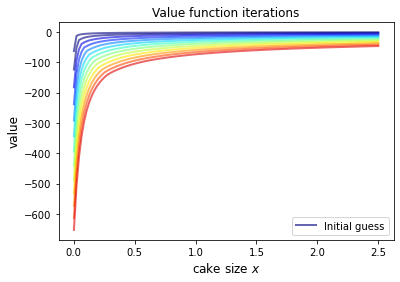

In [8]:
x_grid = ce.x_grid
v = ce.u(x_grid)       # Initial guess
n = 12                 # Number of iterations

fig, ax = plt.subplots()

ax.plot(x_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial guess')

for i in range(n):
    v = T(v, ce)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.legend()
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('cake size $x$', fontsize=12)
ax.set_title('Value function iterations')

plt.show()

To do this more systematically, we introduce a wrapper function called
`compute_value_function` that iterates until some convergence conditions are
satisfied.

In [9]:
def compute_value_function(ce,
                           tol=1e-4,
                           max_iter=1000,
                           verbose=True,
                           print_skip=25):

    # Set up loop
    v = np.zeros(len(ce.x_grid)) # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, ce)

        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

Now let’s call it, noting that it takes a little while to run.

In [10]:
v = compute_value_function(ce)

Error at iteration 25 is 23.8003755134813.
Error at iteration 50 is 8.577577195046615.
Error at iteration 75 is 3.091330659691039.
Error at iteration 100 is 1.1141054204751981.
Error at iteration 125 is 0.4015199357729671.
Error at iteration 150 is 0.14470646660561215.
Error at iteration 175 is 0.052151735472762084.
Error at iteration 200 is 0.018795314242879613.
Error at iteration 225 is 0.006773769545588948.
Error at iteration 250 is 0.0024412443051460286.
Error at iteration 275 is 0.000879816432870939.
Error at iteration 300 is 0.00031708295398402697.
Error at iteration 325 is 0.00011427565573285392.

Converged in 329 iterations.


Now we can plot and see what the converged value function looks like.

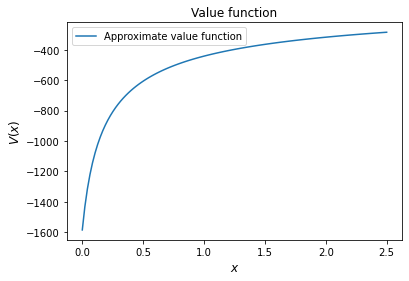

In [11]:
fig, ax = plt.subplots()

ax.plot(x_grid, v, label='Approximate value function')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

Next let’s compare it to the analytical solution.

In [12]:
v_analytical = v_star(ce.x_grid, ce.β, ce.γ)

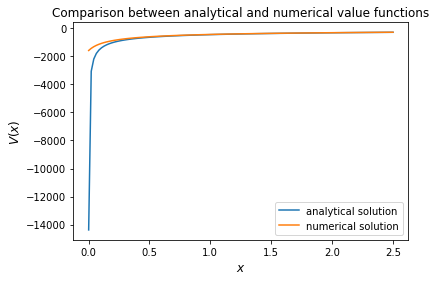

In [13]:
fig, ax = plt.subplots()

ax.plot(x_grid, v_analytical, label='analytical solution')
ax.plot(x_grid, v, label='numerical solution')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.legend()
ax.set_title('Comparison between analytical and numerical value functions')
plt.show()

The quality of approximation is reasonably good for large $ x $, but
less so near the lower boundary.

The reason is that the utility function and hence value function is very
steep near the lower boundary, and hence hard to approximate.

### Policy Function

Let’s see how this plays out in terms of computing the optimal policy.

In the [first lecture on cake eating](https://python.quantecon.org/cake_eating_problem.html), the optimal
consumption policy was shown to be

$$
\sigma^*(x) = \left(1-\beta^{1/\gamma} \right) x
$$

Let’s see if our numerical results lead to something similar.

Our numerical strategy will be to compute

$$
\sigma(x) = \arg \max_{0 \leq c \leq x} \{u(c) + \beta v(x - c)\}
$$

on a grid of $ x $ points and then interpolate.

For $ v $ we will use the approximation of the value function we obtained
above.

Here’s the function:

In [14]:
def σ(ce, v):
    """
    The optimal policy function. Given the value function,
    it finds optimal consumption in each state.

    * ce is an instance of CakeEating
    * v is a value function array

    """
    c = np.empty_like(v)

    for i in range(len(ce.x_grid)):
        x = ce.x_grid[i]
        # Maximize RHS of Bellman equation at state x
        c[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[0]

    return c

Now let’s pass the approximate value function and compute optimal consumption:

In [15]:
c = σ(ce, v)


<a id='pol-an'></a>
Let’s plot this next to the true analytical solution

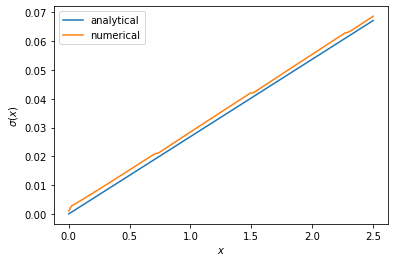

In [16]:
c_analytical = c_star(ce.x_grid, ce.β, ce.γ)

fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label='analytical')
ax.plot(ce.x_grid, c, label='numerical')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_xlabel('$x$')
ax.legend()

plt.show()

The fit is reasonable but not perfect.

We can improve it by increasing the grid size or reducing the
error tolerance in the value function iteration routine.

However, both changes will lead to a longer compute time.

Another possibility is to use an alternative algorithm, which offers the
possibility of faster compute time and, at the same time, more accuracy.

We explore this next.

## Time Iteration

Now let’s look at a different strategy to compute the optimal policy.

Recall that the optimal policy satisfies the Euler equation


<a id='equation-euler-cen'></a>
$$
u' (\sigma(x)) = \beta u' ( \sigma(x - \sigma(x)))
\quad \text{for all } x > 0 \tag{2}
$$

Computationally, we can start with any initial guess of
$ \sigma_0 $ and now choose $ c $ to solve

$$
u^{\prime}( c ) = \beta u^{\prime} (\sigma_0(x - c))
$$

Choosing $ c $ to satisfy this equation at all $ x > 0 $ produces a function of $ x $.

Call this new function $ \sigma_1 $, treat it as the new guess and
repeat.

This is called **time iteration**.

As with value function iteration, we can view the update step as action of an
operator, this time denoted by $ K $.

- In particular, $ K\sigma $ is the policy updated from $ \sigma $
  using the procedure just described.  
- We will use this terminology in the exercises below.  


The main advantage of time iteration relative to value function iteration is that it operates in policy space rather than value function space.

This is helpful because the policy function has less curvature, and hence is easier to approximate.

In the exercises you are asked to implement time iteration and compare it to
value function iteration.

You should find that the method is faster and more accurate.

This is due to

1. the curvature issue mentioned just above  and  
1. the fact that we are using more information — in this case, the first order conditions.  

## Exercises

### Exercise 1

Try the following modification of the problem.

Instead of the cake size changing according to $ x_{t+1} = x_t - c_t $,
let it change according to

$$
x_{t+1} = (x_t - c_t)^{\alpha}
$$

where $ \alpha $ is a parameter satisfying $ 0 < \alpha < 1 $.

(We will see this kind of update rule when we study optimal growth models.)

Make the required changes to value function iteration code and plot the value and policy functions.

Try to reuse as much code as possible.

### Exercise 2

Implement time iteration, returning to the original case (i.e., dropping the
modification in the exercise above).

## Solutions

### Exercise 1

We need to create a class to hold our primitives and return the right hand side of the Bellman equation.

We will use [inheritance](https://en.wikipedia.org/wiki/Inheritance_%28object-oriented_programming%29) to maximize code reuse.

In [17]:
class OptimalGrowth(CakeEating):
    """
    A subclass of CakeEating that adds the parameter α and overrides
    the state_action_value method.
    """

    def __init__(self,
                 β=0.96,           # discount factor
                 γ=1.5,            # degree of relative risk aversion
                 α=0.4,            # productivity parameter
                 x_grid_min=1e-3,  # exclude zero for numerical stability
                 x_grid_max=2.5,   # size of cake
                 x_grid_size=120):

        self.α = α
        CakeEating.__init__(self, β, γ, x_grid_min, x_grid_max, x_grid_size)

    def state_action_value(self, c, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        u, β, α = self.u, self.β, self.α
        v = lambda x: interp(self.x_grid, v_array, x)

        return u(c) + β * v((x - c)**α)

In [18]:
og = OptimalGrowth()

Here’s the computed value function.

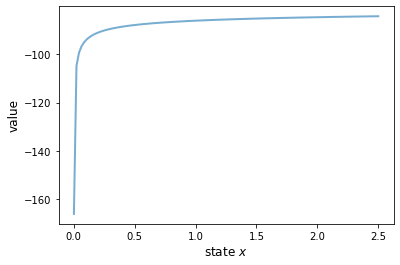

In [19]:
v = compute_value_function(og, verbose=False)

fig, ax = plt.subplots()

ax.plot(x_grid, v, lw=2, alpha=0.6)
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('state $x$', fontsize=12)

plt.show()

Here’s the computed policy, combined with the solution we derived above for
the standard cake eating case $ \alpha=1 $.

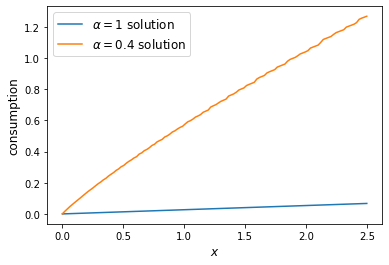

In [20]:
c_new = σ(og, v)

fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label=r'$\alpha=1$ solution')
ax.plot(ce.x_grid, c_new, label=fr'$\alpha={og.α}$ solution')

ax.set_ylabel('consumption', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)

ax.legend(fontsize=12)

plt.show()

Consumption is higher when $ \alpha < 1 $ because, at least for large $ x $, the return to savings is lower.

### Exercise 2

Here’s one way to implement time iteration.

In [21]:
def K(σ_array, ce):
    """
    The policy function operator. Given the policy function,
    it updates the optimal consumption using Euler equation.

    * σ_array is an array of policy function values on the grid
    * ce is an instance of CakeEating

    """

    u_prime, β, x_grid = ce.u_prime, ce.β, ce.x_grid
    σ_new = np.empty_like(σ_array)

    σ = lambda x: interp(x_grid, σ_array, x)

    def euler_diff(c, x):
        return u_prime(c) - β * u_prime(σ(x - c))

    for i, x in enumerate(x_grid):

        # handle small x separately --- helps numerical stability
        if x < 1e-12:
            σ_new[i] = 0.0

        # handle other x
        else:
            σ_new[i] = bisect(euler_diff, 1e-10, x - 1e-10, x)

    return σ_new

In [22]:
def iterate_euler_equation(ce,
                           max_iter=500,
                           tol=1e-5,
                           verbose=True,
                           print_skip=25):

    x_grid = ce.x_grid

    σ = np.copy(x_grid)        # initial guess

    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        σ_new = K(σ, ce)

        error = np.max(np.abs(σ_new - σ))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ

In [23]:
ce = CakeEating(x_grid_min=0.0)
c_euler = iterate_euler_equation(ce)

Error at iteration 25 is 0.0036456675931543225.
Error at iteration 50 is 0.0008283185047067848.
Error at iteration 75 is 0.00030791132300957147.
Error at iteration 100 is 0.00013555502390599772.
Error at iteration 125 is 6.417740905302616e-05.
Error at iteration 150 is 3.1438019047758115e-05.
Error at iteration 175 is 1.5658492883291464e-05.

Converged in 192 iterations.


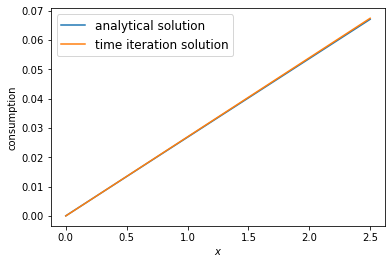

In [24]:
fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label='analytical solution')
ax.plot(ce.x_grid, c_euler, label='time iteration solution')

ax.set_ylabel('consumption')
ax.set_xlabel('$x$')
ax.legend(fontsize=12)

plt.show()